In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
S_seeds = [30525, 122216, 917012]
S_names = ["No Mis/Disinformants", "Out-D Misinformants", "Out-D Disinformants", "WtC Misinformants", "WtC Disinformants", "PageRank Misinformants", "PageRank Disinformants"]

avg_df = pd.read_pickle("avg_sim_output.pkl")

raw_df = pd.read_pickle("raw_sim_output.xz")

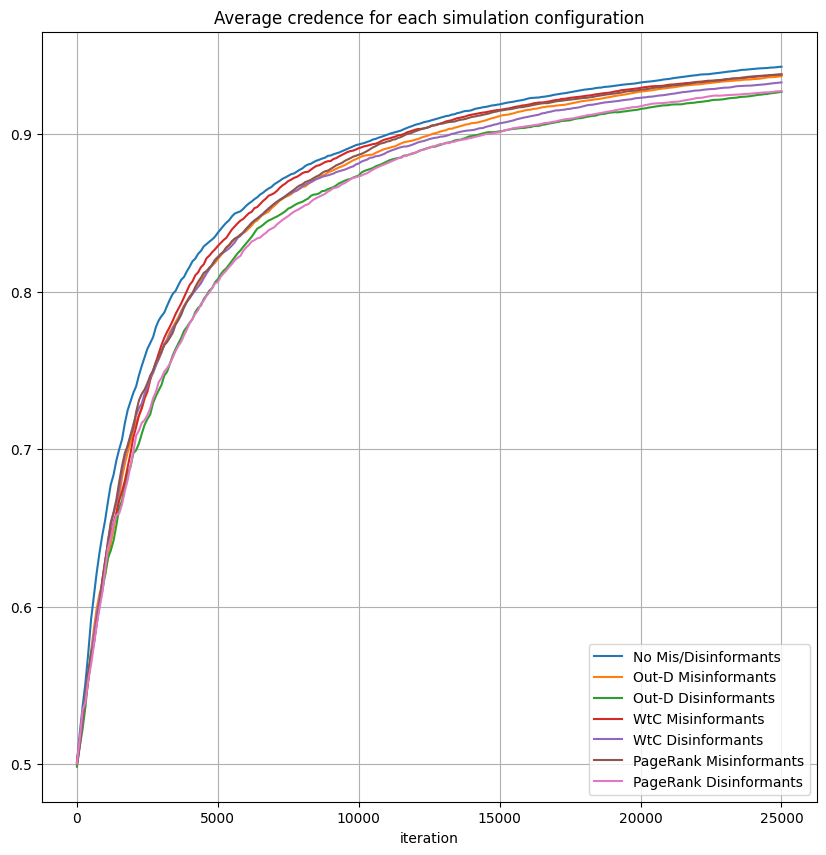

In [4]:
fig, ax = plt.subplots()
fig.set_size_inches(10,10)

avg_df.plot(ax=ax, title="Average credence for each simulation configuration") 

ax.grid(visible=True)

# Uncomment below lines to save plot to file rather than show in notebook
#plt.savefig('avg_credence_all.png')
#plt.close() 

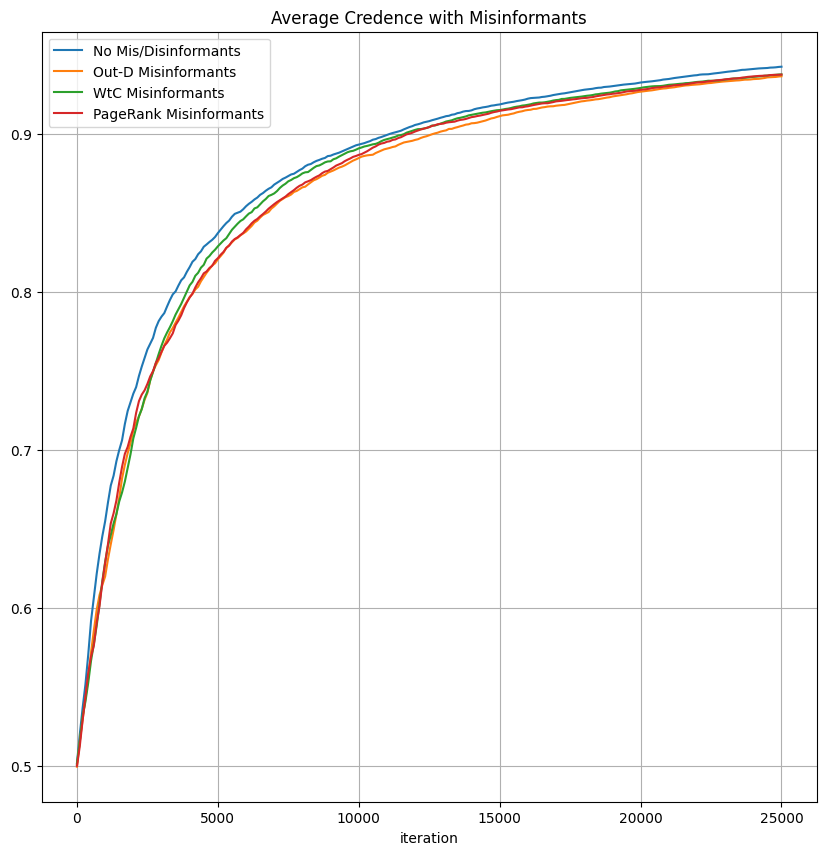

In [5]:
fig, ax = plt.subplots()
fig.set_size_inches(10,10)

avg_df.filter(like='Mis').plot(ax=ax, title="Average Credence with Misinformants") 

ax.grid(visible=True)

# Uncomment below lines to save plot to file rather than show in notebook
#plt.savefig('avg_credence_misinfo.png')
#plt.close() 

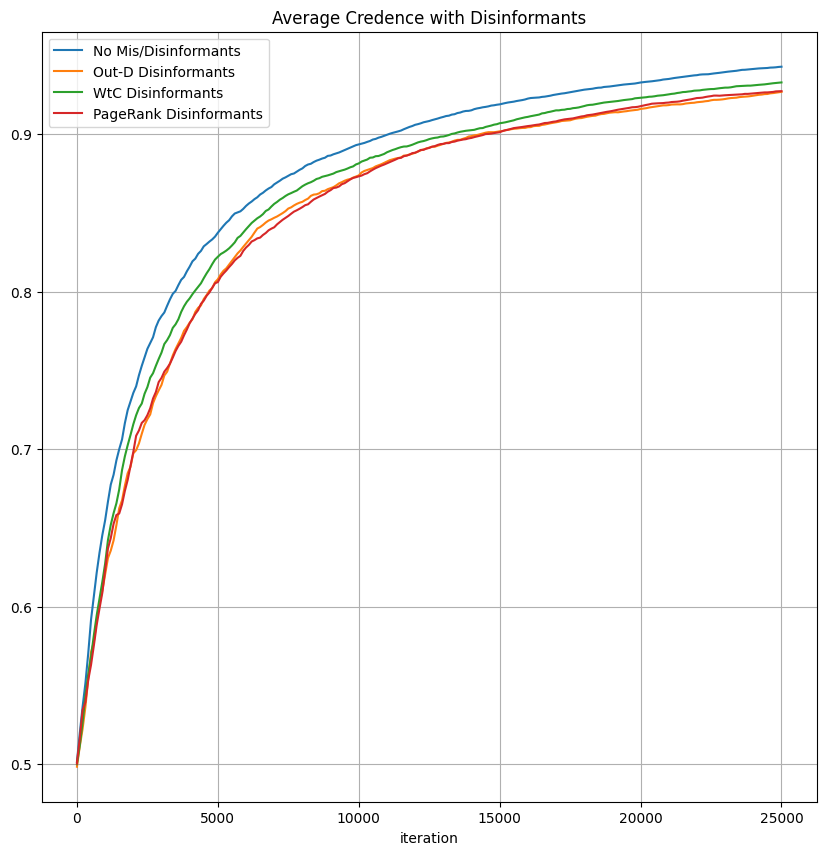

In [6]:
fig, ax = plt.subplots()
fig.set_size_inches(10,10)

avg_df.filter(like='Disinformants').plot(ax=ax, title="Average Credence with Disinformants") 

ax.grid(visible=True)

# Uncomment below lines to save plot to file rather than show in notebook
#plt.savefig('avg_credence_disinfo.png')
#plt.close() 

This figure is something of a sanity check, seeing what effect randomly assigning mis- and disinformants would do to a network.
It turns out that it does nothing; ~1% of nodes being mis- and disinformants is only a little bit of noise to the performance of the network.
This is even though the random sampling oversamples from high out-degree nodes.

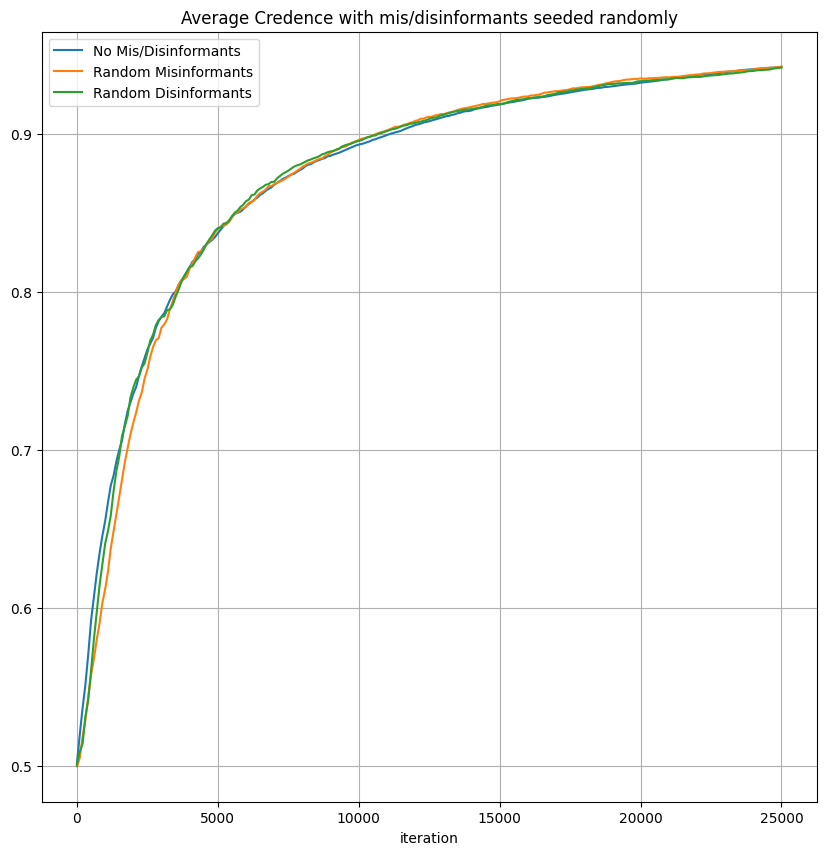

In [7]:
rnd_df = pd.read_pickle('rnd_sim_output.pkl')

fig, ax = plt.subplots()
fig.set_size_inches(10,10)

avg_df['No Mis/Disinformants'].plot(ax=ax, title="Average Credence with mis/disinformants seeded randomly")
rnd_df['Random Misinformants'].plot(ax=ax)
rnd_df['Random Disinformants'].plot(ax=ax)

ax.grid(visible=True)
ax.legend()

# Uncomment below lines to save plot to file rather than show in notebook
#plt.savefig('Rnd_mis_disinfo.png')
#plt.close() 

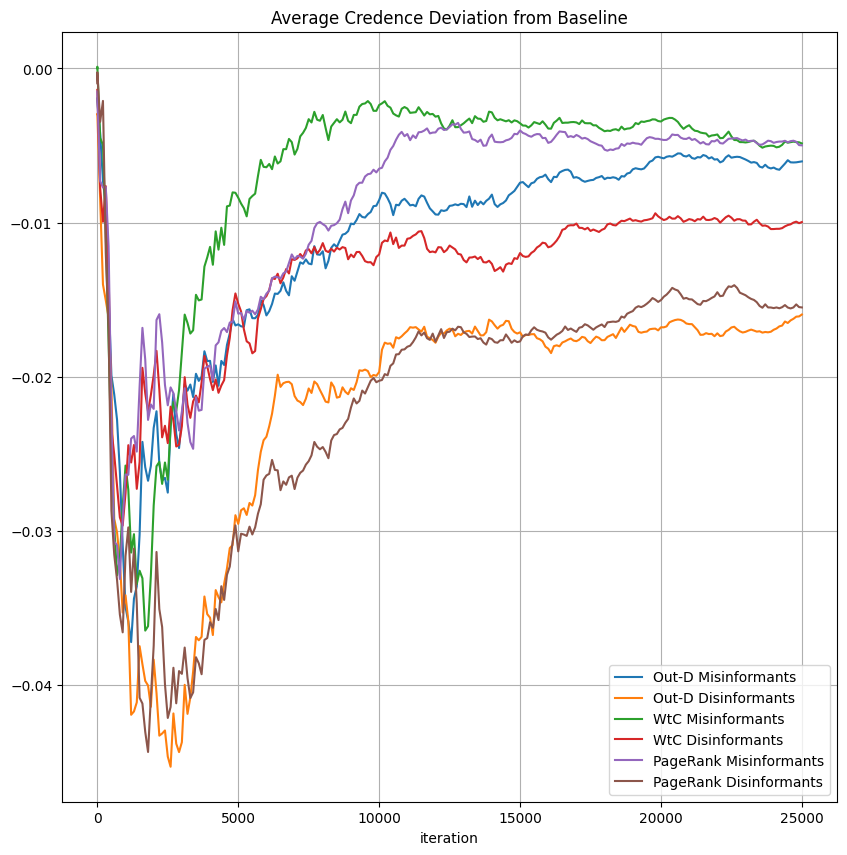

In [8]:
fig, ax = plt.subplots(1,1)
ax.set_title("Average Credence Deviation from Baseline")
fig.set_size_inches(10,10)

for c in avg_df.loc[:, avg_df.columns != 'No Mis/Disinformants']:
	avg_df[c].squeeze().sub(avg_df['No Mis/Disinformants'].squeeze()).plot(ax=ax, label=c)
ax.legend()
ax.grid(visible=True)

# Uncomment below lines to save plot to file rather than show in notebook
#plt.savefig('avg_credence_deviation.png')
#plt.close() 

For the inward measures, we first load the DataFrame containing the network centrality measures for all of the nodes. We generated these before doing the simulations.

In [9]:
import json

cent_df = pd.read_json('centrality.json', orient='columns')
cent_df.set_index('gml_id', inplace=True)

print(cent_df.head())

        outd  ind        pr   S   St  H  Ht  S_cluster
gml_id                                                
0         41   32  0.001275  12   15  3   3          1
1          1   51  0.009412  15    0  3   0          1
2         84   77  0.002095  15   20  3   4          1
3         56   62  0.001723  10   15  3   3          1
4         89   74  0.002436  30  105  3   6          0


For the following graphs we only look at one configuration of the simulation, set by the _config_ variable (I selected OutD_Disinfo with seed 30525).
That greatly simplifies the data manipulation.
The results are very similar across all configurations, so I chose one where the effect on the performance of the network was the largest.
But again, even if we look at the baseline case the results are so close as to make no difference.
The difference is that between the different configurations, the slope of the lines are slightly less steep the worse-performing the network is under that configuration.

First, we look at the distribution of the other inward measures (in-degree and PageRank) in the clusters by S-score.

/tmp/ipykernel_1042/536448546.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([cluster_labels.get(label, label) for label in ax.get_xticks()])


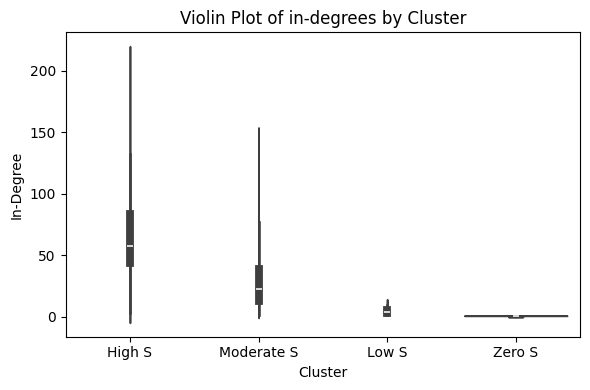

In [10]:
import seaborn as sns

# Define custom labels for clusters
cluster_labels = {
    0: 'High S',
	1: 'Moderate S',
    2: 'Low S',
    3: 'Zero S',
}

config = raw_df.xs(30525)['Out-D Disinformants']

df_merged = pd.merge(config.reset_index(), cent_df[['S', 'S_cluster', 'ind', 'outd', 'pr']], on='gml_id', how='left') # merge data with centrality measures and cluster id

plt.figure(figsize=(6, 4))
ax = sns.violinplot(x='S_cluster', y='ind', data=df_merged)
ax.set_xticklabels([cluster_labels.get(label, label) for label in ax.get_xticks()])
ax.set_title('Violin Plot of in-degrees by Cluster')
ax.set_xlabel('Cluster')
ax.set_ylabel('In-Degree')
plt.tight_layout()

# Uncomment below lines to save plot to file rather than show in notebook
#plt.savefig('violin_plot_pr_by_cluster.png')
#plt.close()


/tmp/ipykernel_1042/2314605323.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([cluster_labels.get(label, label) for label in ax.get_xticks()])


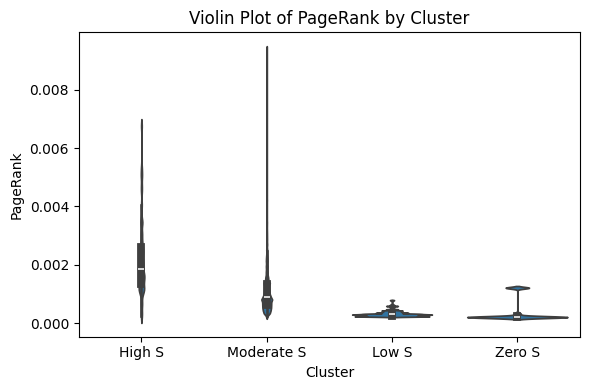

In [11]:

plt.figure(figsize=(6, 4))
ax = sns.violinplot(x='S_cluster', y='pr', data=df_merged)
ax.set_xticklabels([cluster_labels.get(label, label) for label in ax.get_xticks()])
ax.set_title('Violin Plot of PageRank by Cluster')
ax.set_xlabel('Cluster')
ax.set_ylabel('PageRank')
plt.tight_layout()

# Uncomment below lines to save plot to file rather than show in notebook
#plt.savefig('violin_plot_indegrees_by_cluster.png')
#plt.close()


We graph the average credence by cluster.

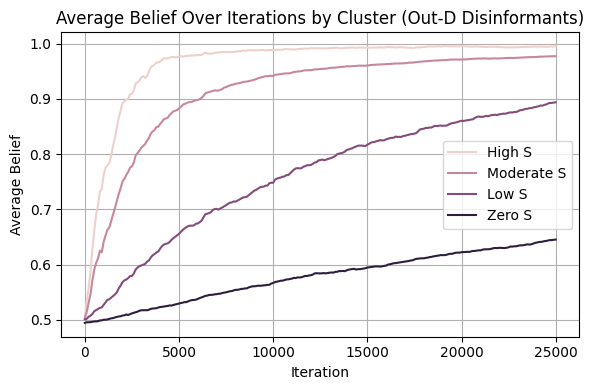

In [12]:

# Group by cluster and compute average belief
avg_belief_by_cluster = df_merged.groupby('S_cluster')[config.name].mean()

# --- Line Plot of Average Belief Over Iterations ---
df_avg_iter = df_merged.groupby(['iteration', 'S_cluster'])[config.name].mean().reset_index()

plt.figure(figsize=(6, 4))
ax = sns.lineplot(data=df_avg_iter, x='iteration', y=config.name, hue='S_cluster')

# Customize legend with descriptive labels
handles, labels = ax.get_legend_handles_labels()
new_labels = [cluster_labels.get(int(label), label) for label in labels]
ax.legend(handles=handles, labels=new_labels)

ax.set_title(f'Average Belief Over Iterations by Cluster ({config.name})')
ax.set_xlabel('Iteration')
ax.set_ylabel('Average Belief')
ax.grid(visible=True)
plt.tight_layout()

# Uncomment below lines to save plot to file rather than show in notebook
#plt.savefig(f'{config.name}_avg_belief_by_cluster.png')
#plt.close()


Generate violin plots describing the distribution of credences at every 5000 iterations for each cluster of nodes by S-score (cluster number is hard-coded at 0-3).

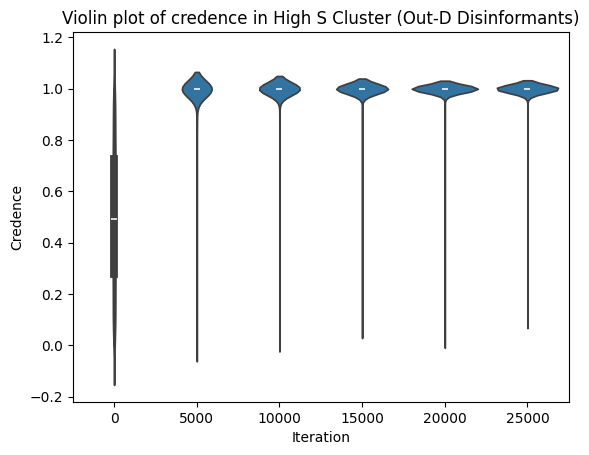

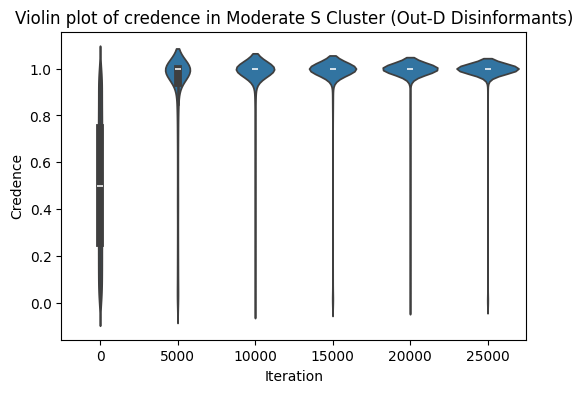

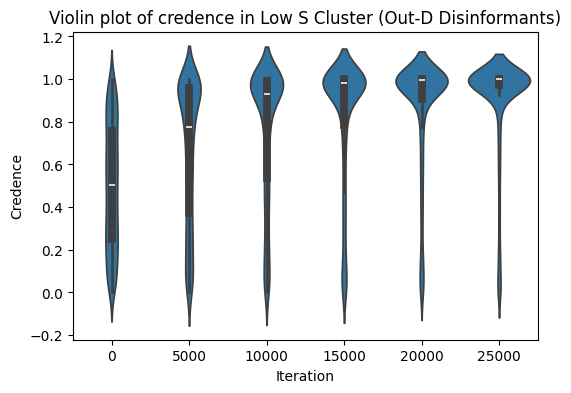

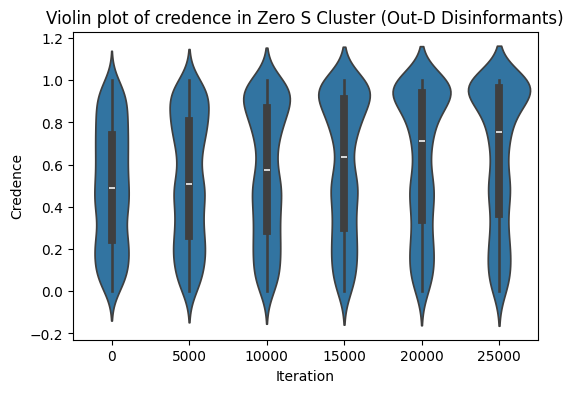

<Figure size 600x400 with 0 Axes>

In [13]:

for c in range(4):  # For each cluster from 0 to 3
  
    ax = sns.violinplot(x='iteration', y=config.name, data=df_merged[(df_merged['iteration'] % 5000 == 0) & (df_merged['S_cluster'] == (c))]) 

    plt.figure(figsize=(6,4))
    ax.set_title(f'Violin plot of credence in {cluster_labels[c]} Cluster ({config.name})')
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Credence')

    #plt.tight_layout()
   
    # Uncomment below lines to save plot to file rather than show in notebook
    #plt.savefig(f'{config.name}_violin_Scluster{c}_over_iterations.png')
    #plt.close()

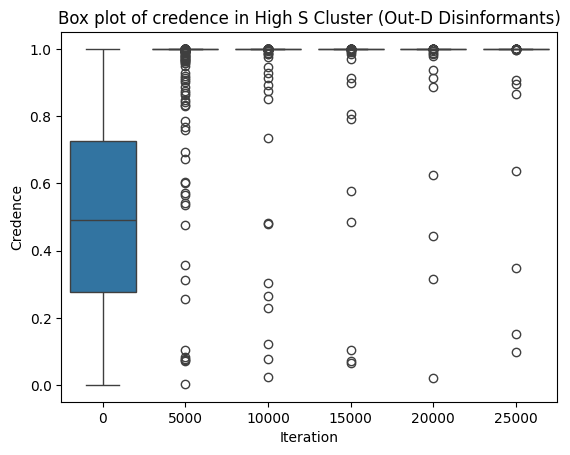

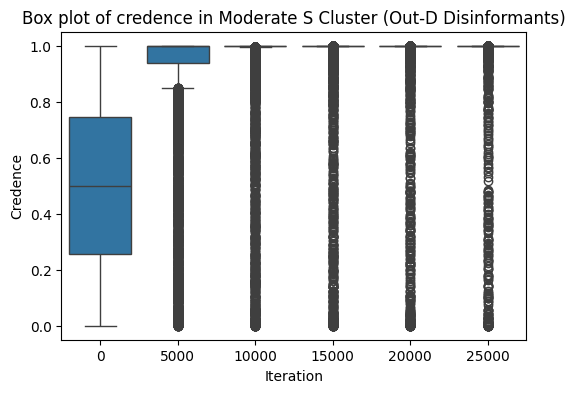

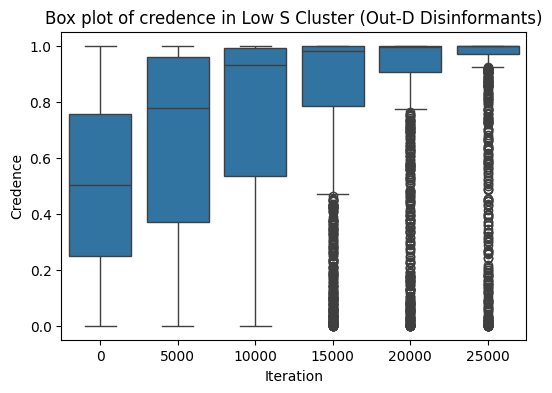

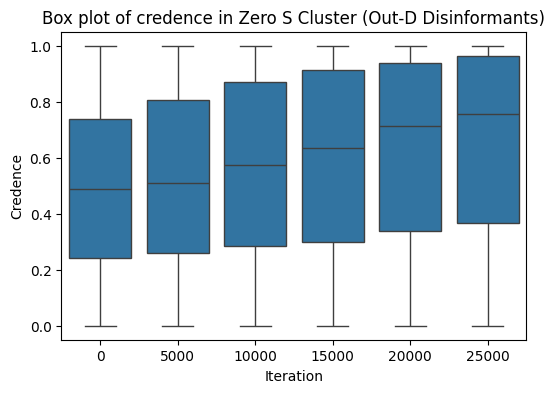

<Figure size 600x400 with 0 Axes>

In [14]:

for c in range(4):  # For each cluster from 0 to 3
  
    ax = sns.boxplot(x='iteration', y=config.name, data=df_merged[(df_merged['iteration'] % 5000 == 0) & (df_merged['S_cluster'] == (c))]) 

    plt.figure(figsize=(6,4))
    ax.set_title(f'Box plot of credence in {cluster_labels[c]} Cluster ({config.name})')
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Credence')

    #plt.tight_layout()
   
    # Uncomment below lines to save plot to file rather than show in notebook
    #plt.savefig(f'{config.name}_boxplot_Scluster{c}_over_iterations.png')
    #plt.close()